In [1]:
import os
import h5py
import numpy as np 
# -- astrologs -- 
from astrologs.astrologs import Astrologs
# -- galpopfm -- 
from galpopfm.catalogs import Catalog
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

Lets read in data from SDSS, SIMBA, and TNG

In [3]:
sdss = Astrologs("tinkergroup", mlim='9.7')

In [4]:
zmax = sdss.data['redshift'].max()
zmin = sdss.data['redshift'].min() 
print('%f < z_sdss < %f' % (zmin, zmax))

0.010698 < z_sdss < 0.033380


In [7]:
from astropy.cosmology import Planck13 as cosmo
vol_sdss = (cosmo.comoving_volume(zmax).value - cosmo.comoving_volume(zmin).value) * (7818.28/41253.) * cosmo.h**3 # (Mpc/h)^3
print('comoving volume = %.2f (Mpc/h)^3' % vol_sdss)

comoving volume = 751134.24 (Mpc/h)^3


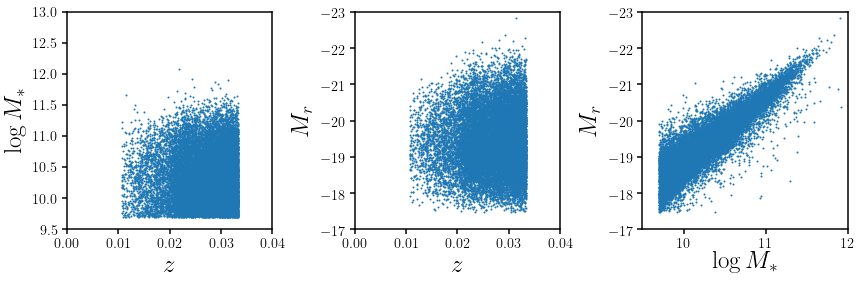

In [5]:
fig = plt.figure(figsize=(14,4))
sub = fig.add_subplot(131)
sub.scatter(sdss.data['redshift'], sdss.data['log.M_star'], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.04)
sub.set_ylabel(r'$\log M_*$', fontsize=25)
sub.set_ylim(9.5, 13.)

sub = fig.add_subplot(132)
sub.scatter(sdss.data['redshift'], sdss.data['M_r'], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.04)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

sub = fig.add_subplot(133)
sub.scatter(sdss.data['log.M_star'], sdss.data['M_r'], s=1)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9.5, 12.)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

fig.subplots_adjust(wspace=0.4)

In [11]:
simba = Catalog('simba')
tng = Catalog('tng')

In [9]:
vol_simba = 100.**3 # (Mpc/h)^3
vol_tng = 75.**3 # (Mpc/h)^3

In [17]:
logms_bin = np.linspace(8., 13., 26)
dlogms = logms_bin[1:] - logms_bin[:-1]

Now calculate the SMFs

In [18]:
Ngal_sdss, _ = np.histogram(sdss.data['log.M_star'], bins=logms_bin) 
Ngal_simba, _ = np.histogram(simba.data['logmstar'], bins=logms_bin)
Ngal_tng, _ = np.histogram(tng.data['logmstar'], bins=logms_bin)

In [19]:
phi_sdss = Ngal_sdss.astype(float) / vol_sdss / dlogms
phi_simba = Ngal_simba.astype(float) / vol_simba / dlogms
phi_tng = Ngal_tng.astype(float) / vol_tng / dlogms

(3.072612680674748e-06, 0.137935453071537)

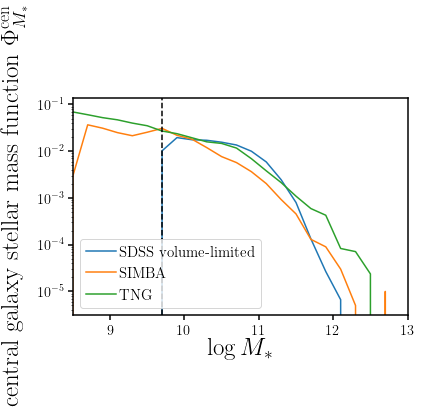

In [20]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_sdss, label='SDSS volume-limited')
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_simba, label='SIMBA')
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_tng, label='TNG')
sub.legend(loc='lower left', frameon=True, handletextpad=0.2, fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 13.)
sub.set_ylabel(r'central galaxy stellar mass function $\Phi^{\rm cen}_{M_*}$', fontsize=25)
sub.set_yscale("log")
ylim = sub.get_ylim()
sub.plot([9.7, 9.7], ylim, c='k', ls='--')
sub.set_ylim(ylim)

Now lets calculate jackknife errors for the SDSS SMF

(-30.0, 90.0)

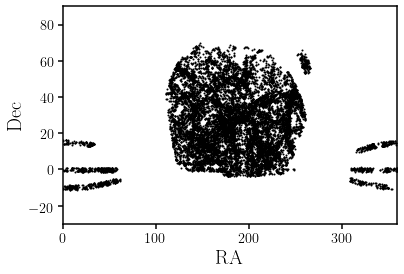

In [23]:
ra_sdss = sdss.data['ra'] * (180./np.pi)
dec_sdss = sdss.data['dec'] * (180./np.pi)

plt.scatter(ra_sdss, dec_sdss, c='k', s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [24]:
jk_fields = [] 
jk_fields.append(ra_sdss < 100)

ra_bins = np.linspace(110, 270, 4)
dec_bins = np.linspace(-11., 70., 4)
for i in range(len(ra_bins)-1): 
    for j in range(len(dec_bins)-1): 
        infield = ((ra_sdss > ra_bins[i]) & (ra_sdss < ra_bins[i+1]) & 
                   (dec_sdss > dec_bins[j]) & (dec_sdss < dec_bins[j+1]))
        jk_fields.append(infield)
jk_fields.append(ra_sdss > 300)

for i, field in enumerate(jk_fields): 
    print('field %i: %i' % (i, np.sum(field)))

field 0: 735
field 1: 1287
field 2: 2171
field 3: 1104
field 4: 1917
field 5: 3904
field 6: 1229
field 7: 1125
field 8: 2364
field 9: 602
field 10: 532


(-30.0, 90.0)

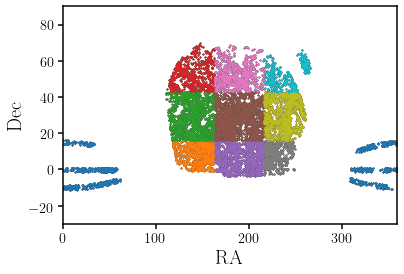

In [25]:
plt.scatter(ra_sdss, dec_sdss, c='k', s=1)
for field in jk_fields: 
    plt.scatter(ra_sdss[field], dec_sdss[field], s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [27]:
jk_phis = [] 
for field in jk_fields: 
    _Ngal, _ = np.histogram(sdss.data['log.M_star'][~field], bins=logms_bin) 
    _phi = _Ngal.astype(float) / vol_sdss / dlogms
    jk_phis.append(_phi)

n_jk = len(jk_phis)
jk_avg_phi = np.sum(np.array(jk_phis), axis=0)/float(n_jk)
phi_err_jk = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_phi - jk_avg_phi)**2 for _phi in jk_phis]), axis=0))

(3.072612680674748e-06, 0.137935453071537)

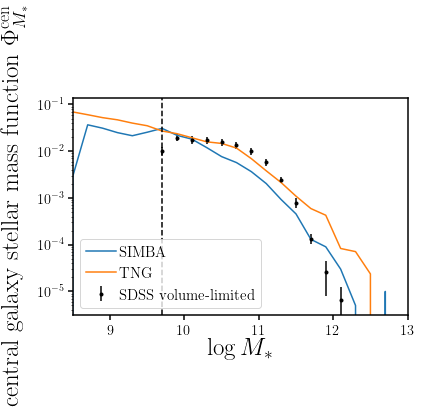

In [28]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_sdss, yerr=phi_err_jk, fmt='.k', label='SDSS volume-limited')
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_simba, label='SIMBA')
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_tng, label='TNG')
sub.legend(loc='lower left', frameon=True, handletextpad=0.2, fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 13.)
sub.set_ylabel(r'central galaxy stellar mass function $\Phi^{\rm cen}_{M_*}$', fontsize=25)
sub.set_yscale("log")
ylim = sub.get_ylim()
sub.plot([9.7, 9.7], ylim, c='k', ls='--')
sub.set_ylim(ylim)

In [29]:
f_phi = os.path.join(dat_dir, 'obs', 'tinker_SDSS_M9.7.phi_logMstar.dat') 
np.savetxt(f_phi, np.array([logms_bin[:-1], logms_bin[1:], phi_sdss, phi_err_jk]).T)

Lets see what the luminosity function looks like. First lets calculate the luminosities of SIMBA and TNG with **no dust attenuation**

In [21]:
from galpopfm import measure_obs as measureObs
R_mag_simba = measureObs.AbsMag_sed(simba['wave'][...], simba['sed_neb'][...], band='r_sdss') 
R_mag_tng = measureObs.AbsMag_sed(tng['wave'][...], tng['sed_neb'][...], band='r_sdss')

In [22]:
mr_bin = np.linspace(-25., -17., 17)
dmr = mr_bin[1:] - mr_bin[:-1]

In [23]:
_Ngal_sdss, _ = np.histogram(sdss['mr_tinker'][...], bins=mr_bin) 
_Ngal_simba, _ = np.histogram(R_mag_simba, bins=mr_bin)
_Ngal_tng, _ = np.histogram(R_mag_tng, bins=mr_bin)

_phi_sdss = _Ngal_sdss.astype(float) / vol_sdss / dmr
_phi_simba = _Ngal_simba.astype(float) / vol_simba / dmr
_phi_tng = _Ngal_tng.astype(float) / vol_tng / dmr

(1.257002616132065e-06, 0.03440329915152186)

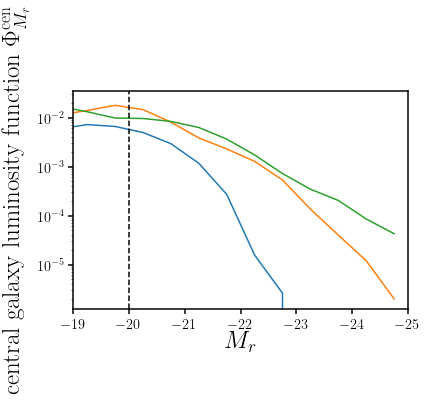

In [24]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(0.5*(mr_bin[1:] + mr_bin[:-1]), _phi_sdss)
sub.plot(0.5*(mr_bin[1:] + mr_bin[:-1]), _phi_simba)
sub.plot(0.5*(mr_bin[1:] + mr_bin[:-1]), _phi_tng)

sub.set_xlabel(r'$M_r$', fontsize=25)
sub.set_xlim(-19., -25.)
sub.set_ylabel(r'central galaxy luminosity function $\Phi^{\rm cen}_{M_r}$', fontsize=25)
sub.set_yscale("log")
ylim = sub.get_ylim()
sub.plot([-20., -20.], ylim, c='k', ls='--')
sub.set_ylim(ylim)

In [25]:
mr_complete = (sdss['mr_tinker'][...] < -20.)

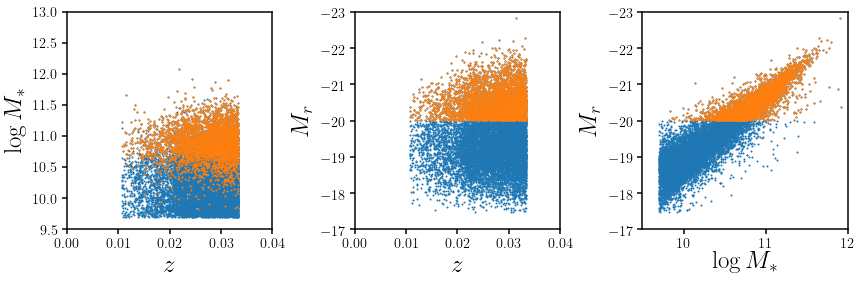

In [26]:
fig = plt.figure(figsize=(14,4))
sub = fig.add_subplot(131)
sub.scatter(z_sdss, logm_sdss, s=1)
sub.scatter(z_sdss[mr_complete], logm_sdss[mr_complete], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.04)
sub.set_ylabel(r'$\log M_*$', fontsize=25)
sub.set_ylim(9.5, 13.)

sub = fig.add_subplot(132)
sub.scatter(z_sdss, sdss['mr_tinker'][...], s=1)
sub.scatter(z_sdss[mr_complete], sdss['mr_tinker'][...][mr_complete], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.04)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

sub = fig.add_subplot(133)
sub.scatter(logm_sdss, sdss['mr_tinker'][...], s=1)
sub.scatter(logm_sdss[mr_complete], sdss['mr_tinker'][...][mr_complete], s=1)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9.5, 12.)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

fig.subplots_adjust(wspace=0.4)

Now lets calculate jack-knife error bars for the luminosity function

In [27]:
mr_sdssmr = sdss['mr_tinker'][...][mr_complete]
ra_sdssmr = sdss['RA'][...][mr_complete]
dec_sdssmr = sdss['DEC'][...][mr_complete]

(-30, 90)

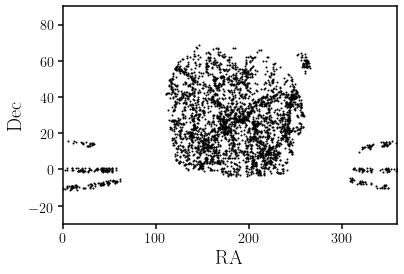

In [28]:
plt.scatter(ra_sdssmr, dec_sdssmr, c='k', s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [29]:
jk_fields = [] 
jk_fields.append(ra_sdssmr < 100)

ra_bins = np.linspace(110, 270, 4)
dec_bins = np.linspace(-11., 70., 4)
for i in range(len(ra_bins)-1): 
    for j in range(len(dec_bins)-1): 
        infield = ((ra_sdssmr > ra_bins[i]) & (ra_sdssmr < ra_bins[i+1]) & 
                   (dec_sdssmr > dec_bins[j]) & (dec_sdssmr < dec_bins[j+1]))
        jk_fields.append(infield)
jk_fields.append(ra_sdssmr > 300)

In [30]:
for i, field in enumerate(jk_fields): 
    print('field %i: %i' % (i, np.sum(field)))

field 0: 232
field 1: 291
field 2: 467
field 3: 242
field 4: 382
field 5: 705
field 6: 293
field 7: 223
field 8: 491
field 9: 127
field 10: 133


(-30, 90)

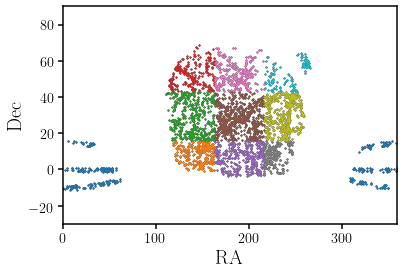

In [31]:
plt.scatter(ra_sdssmr, dec_sdssmr, c='k', s=1)
for field in jk_fields: 
    plt.scatter(ra_sdssmr[field], dec_sdssmr[field], s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [32]:
jk_phis = [] 
for field in jk_fields: 
    _Ngal, _ = np.histogram(mr_sdssmr[~field], bins=mr_bin) 
    _phi = _Ngal.astype(float) / vol_sdss / dmr
    jk_phis.append(_phi)

In [33]:
n_jk = len(jk_phis)

In [34]:
jk_avg_phi = np.sum(np.array(jk_phis), axis=0)/float(n_jk)

In [35]:
phi_err_jk = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_phi - jk_avg_phi)**2 for _phi in jk_phis]), axis=0))

(1.257002616132065e-06, 0.03440329915152186)

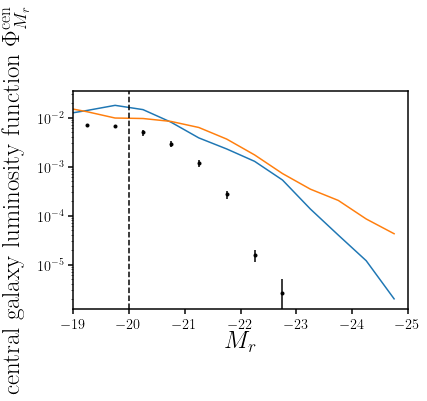

In [36]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(0.5*(mr_bin[1:] + mr_bin[:-1]), _phi_sdss, yerr=phi_err_jk, fmt='.k')
sub.plot(0.5*(mr_bin[1:] + mr_bin[:-1]), _phi_simba)
sub.plot(0.5*(mr_bin[1:] + mr_bin[:-1]), _phi_tng)

sub.set_xlabel(r'$M_r$', fontsize=25)
sub.set_xlim(-19., -25.)
sub.set_ylabel(r'central galaxy luminosity function $\Phi^{\rm cen}_{M_r}$', fontsize=25)
sub.set_yscale("log")
ylim = sub.get_ylim()
sub.plot([-20., -20.], ylim, c='k', ls='--')
sub.set_ylim(ylim)

In [37]:
f_phi = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.phi_Mr.dat') 
np.savetxt(f_phi, np.array([mr_bin[:-1], mr_bin[1:], _phi_sdss, phi_err_jk]).T)